###  Config

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import random
import numpy as np
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


### Knapsack Environment

In [47]:
class KnapsackEnv:
    def __init__(self):
        self.n = 10
        self.weights = np.random.randint(1, 100, self.n)
        self.values = np.random.randint(1, 100, self.n)
        self.capacity = np.random.randint(1, sum(self.weights))

    def reset(self):
        self.selected = np.zeros(self.n, dtype=int)

        self.rem_w = self.capacity
        total_value = self.values.sum()

        # Ma trận state (n+1 items, 3 features) [selected, value, weight]
        self.state = np.zeros((self.n+1, 3), dtype=float)
        for i in range(self.n):
            self.state[i] = [
                0,
                self.values[i] / total_value,
                self.weights[i] / self.capacity
            ]
        # Hàng cuối: capacity còn lại (ban đầu normalized = 1)
        self.state[self.n] = [0, 1.0, 1.0]

        return self.state.flatten().astype(np.float32)

    def step(self, action):
        i = action
        reward = 0.0
        done = False

        # check valid
        if self.selected[i] == 0 and self.weights[i] <= self.rem_w:
            self.selected[i] = 1
            self.rem_w -= self.weights[i]
            reward = float(self.values[i])

            # update flag selected
            self.state[i, 0] = 1.0
            # update remaining capacity
            self.state[self.n] = [0, 0.0, self.rem_w / self.capacity]
        else:
            reward = 0.0

        # check done
        feasible = False
        for j in range(self.n):
            if self.selected[j] == 0 and self.weights[j] <= self.rem_w:
                feasible = True
                break
        if not feasible:
            done = True

        return self.state.flatten().astype(np.float32), reward, done, {}

### Select action

In [48]:
def select_action(env, state, q_net, epsilon):
    # epsilon-greedy exploration
    if random.random() < epsilon:
        # explore: chọn ngẫu nhiên trong các action hợp lệ
        valid_actions = []
        for i in range(env.n):
            if env.selected[i] == 0 and env.weights[i] <= env.rem_w:
                valid_actions.append(i)
        if valid_actions:
            return random.choice(valid_actions)
        else:
            return None # không có action hợp lệ
    else:
        # exploit: chọn action có Q lớn nhất
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = q_net(state_t).detach().cpu().numpy().squeeze()

        # mask: True neu item hop le
        mask = np.zeros(env.n, dtype=bool)
        for i in range(env.n):
            if env.selected[i] == 0 and env.weights[i] <= env.rem_w:
                mask[i] = True

        # neu khong con action hop le
        if not mask.any():
            return None
        q_values[~mask] = -1e9

        # chon action co Q lon nhat
        action = int(np.argmax(q_values))
        return action

### Dueling DQN

In [49]:
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, n_actions, hidden_dim=128):
        super().__init__()
        # phần chung (feature extractor)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # value stream
        self.v_fc = nn.Linear(hidden_dim, hidden_dim)
        self.v_out = nn.Linear(hidden_dim, 1)

        # advantage stream
        self.a_fc = nn.Linear(hidden_dim, hidden_dim)
        self.a_out = nn.Linear(hidden_dim, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # value branch
        v = F.relu(self.v_fc(x))
        v = self.v_out(v)  # shape: (batch, 1)

        # advantage branch
        a = F.relu(self.a_fc(x))
        a = self.a_out(a)  # shape: (batch, n_actions)

        # combine theo công thức dueling
        q = v + a - a.mean(dim=1, keepdim=True)
        return q

### Replay Buffer

In [50]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)

### Train step

In [51]:
def train_step(online_net, target_net, buffer, optimizer, batch_size=64, gamma=0.99):
    if len(buffer) < batch_size:
        return None  # chưa đủ dữ liệu để train

    # Sample minibatch
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    # Convert sang tensor
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Q-values cho actions đã chọn
    q_values = online_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Double DQN target
    with torch.no_grad():
        next_actions = online_net(next_states).argmax(dim=1)  # chọn action bằng online_net
        next_q = target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        target = rewards + gamma * next_q * (1 - dones)

    # Loss = MSE
    loss = F.mse_loss(q_values, target)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

## Training Model

In [ ]:
# Hyperparameters
n_items = 10
episodes = 200        # để test, bài báo dùng vài ngàn
buffer_capacity = 5000
batch_size = 8
gamma = 0.99
lr = 1e-2
# target_update_freq = 100
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.965  # decay factor

# Env + networks
env = KnapsackEnv()
input_dim = (n_items+1) * 3
n_actions = n_items

online_net = DuelingDQN(input_dim, n_actions, hidden_dim=16).to(device)
target_net = DuelingDQN(input_dim, n_actions, hidden_dim=16).to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = optim.Adam(online_net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=4, gamma=0.875)
buffer = ReplayBuffer(capacity=buffer_capacity)

epsilon = epsilon_start

# Training
all_rewards = []
for ep in tqdm(range(episodes), desc="Training"):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(env, state, online_net, epsilon) # dùng epsilon-greedy
        if action is None:
            break
        next_state, reward, done, _ = env.step(action)
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # train step
        loss = train_step(online_net, target_net, buffer, optimizer,
                          batch_size=batch_size, gamma=gamma)

    all_rewards.append(total_reward)
    scheduler.step()
    target_net.load_state_dict(online_net.state_dict())

    # Epsilon decay
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

print(f"Current epsilon = {epsilon:.6f}")
print(f"Current LR = {scheduler.get_last_lr()[0]:.6f}")
print("\nTraining done.")

Training: 100%|██████████| 200/200 [00:01<00:00, 131.64it/s]

Current epsilon = 0.010000
Current LR = 0.000013

Training done.


## Evaluating

In [53]:
def knapsack_dp(weights, values, capacity):
    n = len(weights)
    dp = [0] * (capacity + 1)
    for i in range(n):
        w, v = weights[i], values[i]
        for cap in range(capacity, w-1, -1):
            dp[cap] = max(dp[cap], dp[cap-w] + v)
    return max(dp)

def knapsack_greedy(weights, values, capacity):
    n = len(weights)
    ratio = [v / w for w, v in zip(weights, values)]
    indices = sorted(range(n), key=lambda k: ratio[k], reverse=True)
    total_value = 0
    total_weight = 0
    for i in indices:
        if total_weight + weights[i] <= capacity:
            total_value += values[i]
            total_weight += weights[i]
    return total_value

def evaluate_graph(env, model, n_eval=100):
    dp_results = []
    greedy_results = []
    agent_results = []
    for _ in tqdm(range(n_eval), desc="Evaluating"):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = select_action(env, state, model, epsilon=0)
            if action is None:
                break
            state, reward, done, _ = env.step(action)
            total_reward += reward
        dp_result = knapsack_dp(env.weights, env.values, env.capacity)
        greedy_result = knapsack_greedy(env.weights, env.values, env.capacity)
        dp_results.append(dp_result)
        greedy_results.append(greedy_result)
        agent_results.append(total_reward)
    return dp_results, greedy_results, agent_results

Evaluating: 100%|██████████| 200/200 [00:00<00:00, 650.05it/s]


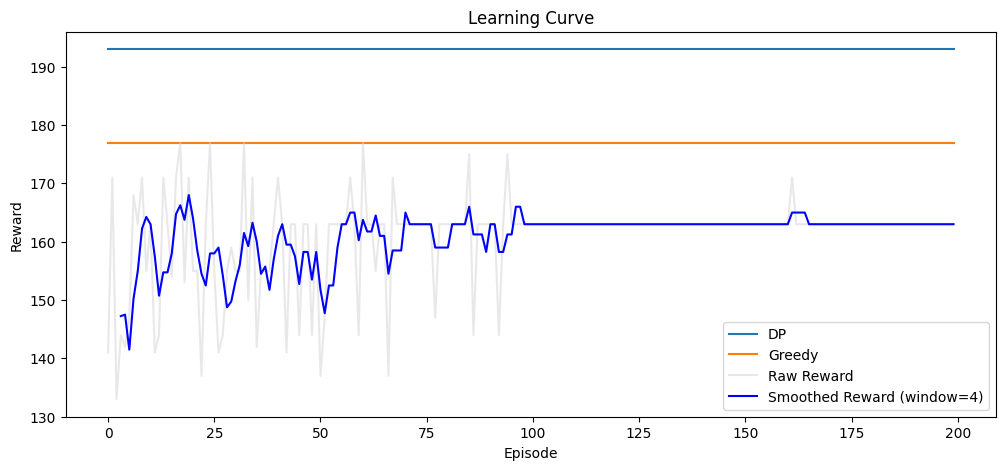

In [54]:
dp_results, greedy_results, agent_results = evaluate_graph(env, online_net, n_eval=episodes)

# Làm mịn bằng trung bình trượt (moving average)
window = 4  # số episode để làm mịn
smoothed_rewards = np.convolve(all_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12,5))
plt.plot(dp_results, label="DP")
plt.plot(greedy_results, label="Greedy")
plt.plot(all_rewards, color='lightgray', label='Raw Reward', alpha=0.5)
plt.plot(np.arange(window-1, len(all_rewards)), smoothed_rewards, color='blue', label=f'Smoothed Reward (window={window})')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Learning Curve")
plt.legend()
plt.show()